In [16]:
!pip install torch==1.6.0
!pip install opencv-python
!pip install torchvision==0.7.0
!pip install albumentations
!pip install tensorflow
!pip install pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.9 MB 10.1 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.2.2
    Uninstalling torchvision-0.2.2:
      Successfully uninstalled torchvision-0.2.2
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import cv2
import matplotlib.pyplot as plt
import time
import glob

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# import resnest.torch as resnest_torch

from torchvision import models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from resnet import ResNet, Bottleneck

from albumentations.core.transforms_interface import DualTransform, BasicTransform
import albumentations as A


from sklearn.model_selection import StratifiedKFold

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## util

In [2]:
config_set = {
    'dataset': {
          'name': 'SpectrogramDataset',
          'params': {
            'img_size': 224, 
            'melspectrogram_parameters': {
              'n_mels': 128, 
              'fmin': 50, 
              'fmax': 15000, 
            }
      }
    },
    'loader': {
      'train': {
        'batch_size': 6,
        'shuffle': True,
        'num_workers': 2,
        'pin_memory': True,
        'drop_last': True,
      },
      'valid': {
        'batch_size': 2,
        'shuffle': False,
        'num_workers': 2,
        'pin_memory': True,
        'drop_last': True,
      }
    }
}
SEED=1213
PERIOD = 5
OK_RANGE = 60
SPECIES_NUM = 24
EPOCH = 50
OUTPUT_DIR = './output/'
HOP_LEN = 512
SR = 48000

In [3]:
config = config_set

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed(SEED)

In [5]:
INPUT_ROOT = Path("/home/knikaido/work/Rainforest-Connection/data")
RAW_DATA = INPUT_ROOT / "rfcx-species-audio-detection"
TRAIN_AUDIO_DIR = RAW_DATA / "train"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test"

In [6]:
class AudioTransform(BasicTransform):
    """ Transform for audio task. This is the main class where we override the targets and update params function for our need"""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params
    
class PitchShift(AudioTransform):
    """ Do time shifting of audio """
    def __init__(self, always_apply=False, p=0.5 , n_steps=None):
        super(PitchShift, self).__init__(always_apply, p)
        '''
        nsteps here is equal to number of semitones
        '''
        
        self.n_steps = n_steps
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''        
        return librosa.effects.pitch_shift(data,sr=SR,n_steps=self.n_steps)
    
class AddGaussianNoise(AudioTransform):
    """ Do time shifting of audio """
    def __init__(self, always_apply=False, p=0.5):
        super(AddGaussianNoise, self).__init__(always_apply, p)
        
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        ''' 
        noise = np.random.randn(len(data))
        data_wn = data + 0.05*noise
        return data_wn
    
class NoAugment(AudioTransform):
    """ Do time shifting of audio """
    def __init__(self, always_apply=False):
        super(NoAugment, self).__init__(always_apply)
        
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        ''' 
        return data
    
def get_augmentation():
    train_transform = [
#         PitchShift(p=1.0,n_steps=4),
        AddGaussianNoise(p=0.2),
    ]
    return A.OneOf(train_transform)  # <- Compose

In [7]:
train_gby = pd.read_pickle(RAW_DATA / "train_gby_wav_raw.pkl")
train_gby

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,name
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,/home/knikaido/work/Rainforest-Connection/data...
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,/home/knikaido/work/Rainforest-Connection/data...
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,/home/knikaido/work/Rainforest-Connection/data...
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,/home/knikaido/work/Rainforest-Connection/data...
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,/home/knikaido/work/Rainforest-Connection/data...
...,...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75,/home/knikaido/work/Rainforest-Connection/data...
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25,/home/knikaido/work/Rainforest-Connection/data...
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00,/home/knikaido/work/Rainforest-Connection/data...
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20,/home/knikaido/work/Rainforest-Connection/data...


In [133]:
train_gby.query('t_max - t_min > 6').sort_values('t_min')

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,name
1115,e7847849b,4,1,0.0267,2343.75,1.8827,4218.75,/home/knikaido/work/Rainforest-Connection/data...
436,590163609,5,1,0.0267,4781.25,2.3787,10406.20,/home/knikaido/work/Rainforest-Connection/data...
1094,e383713d9,23,4,0.0348,6459.96,7.9586,11627.90,/home/knikaido/work/Rainforest-Connection/data...
41,07d1687e0,8,1,0.0640,3750.00,4.1867,5531.25,/home/knikaido/work/Rainforest-Connection/data...
5,00b404881,8,1,0.0747,3750.00,4.1973,5531.25,/home/knikaido/work/Rainforest-Connection/data...
...,...,...,...,...,...,...,...,...
883,b9f3581d5,18,1,58.5333,3187.50,59.2267,5062.50,/home/knikaido/work/Rainforest-Connection/data...
478,5f9157d7b,0,1,58.9333,5906.25,59.7280,8250.00,/home/knikaido/work/Rainforest-Connection/data...
30,055088446,14,1,58.9920,3750.00,59.2640,6468.75,/home/knikaido/work/Rainforest-Connection/data...
846,b1d18170a,14,1,59.0987,3750.00,59.3707,6468.75,/home/knikaido/work/Rainforest-Connection/data...


In [8]:
def mono_to_color(
    X: np.ndarray, mean=None, std=None,
    norm_max=None, norm_min=None, eps=1e-6
):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [167]:
idx = 1

saigo 2184160.5, 2880000
nagai 1944160.5, 1944160.5
saisyo 0.0, 1944160.5
kouho1 = 3797.1884765625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


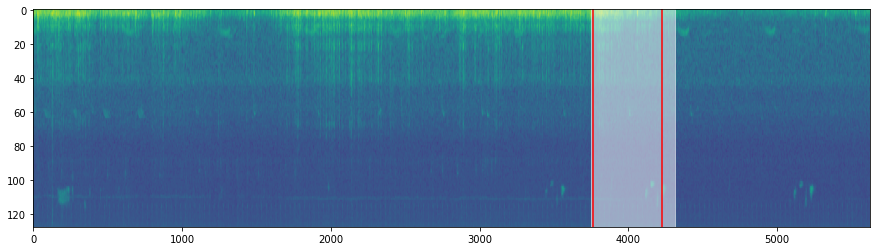

In [207]:
wav_path = train_gby['name'][idx]
train_element = train_gby.iloc[idx]
img_size = 224

y, sr = sf.read(wav_path)

len_y = len(y)
effective_length = sr * PERIOD

tmin = int(SR * train_element['t_min'])
tmax = int(SR * train_element['t_max'])

# 時間かかる
center = (tmax + tmin) / 2
tgt_len = int(tmax - tmin)
# 最後が範囲内かどうか
print(f'saigo {tmax + (effective_length - tgt_len) / 2}, {len_y}')
# 最後が範囲内かどうかで，tgt_lenがeffect_lenより長い時，ここがかわる
print(f'nagai {tmin - (effective_length - tgt_len) / 2}, {min(tmax + (effective_length - tgt_len) / 2, len_y) - effective_length}')
# 最初が範囲内かどうか     
print(f'saisyo {0.0}, {min(tmin - (effective_length - tgt_len) / 2, min(tmax + (effective_length - tgt_len) / 2, len_y) - effective_length)}')

start = int(max(0.0, min(tmin - (effective_length - tgt_len) / 2, min(tmax + (effective_length - tgt_len) / 2, len_y) - effective_length)))
if(effective_length - tgt_len < 0):
    start = np.random.randint(tmin, tmax-effective_length)
end = start + effective_length
# while(1):
#     start = np.random.randint(len_y - effective_length)
#     end = start + effective_length
#     tgt_len = int((tmax - tmin) * 50 / 100)
#     if( (start < tmin and tmin + tgt_len < end) or (start < tmax - tgt_len and tmax < end) ):
#         break

# y = y[start:end].astype(np.float32)
# y = self.transform(data=y)['data']

melspec = librosa.feature.melspectrogram(y, sr=sr, **config["dataset"]["params"]['melspectrogram_parameters'])
melspec = librosa.power_to_db(melspec).astype(np.float32)

# image = mono_to_color(melspec)
# height, width, _ = image.shape
# image = cv2.resize(image, (int(width * img_size / height), img_size))
# image = np.moveaxis(image, 2, 0)
# image = (image / 255.0).astype(np.float32)

plt.figure(figsize=(15, 4))
plt.imshow(melspec)
plt.axvline(x=int(start/HOP_LEN), ymin=0, ymax=128, color='red')
plt.axvline(x=int(end/HOP_LEN), ymin=0, ymax=128, color='red')
plt.axvspan(int(tmin/HOP_LEN), int(tmax/HOP_LEN), color = "white", alpha = 0.5)
plt.axes().set_aspect('auto')
print(f'kouho1 = {(tmin - (effective_length - tgt_len) / 2) / HOP_LEN}')

In [69]:
((tmax + (effective_length - tgt_len))/HOP_LEN)

4644.75

In [9]:
class SpectrogramTrainDataset(data.Dataset):
    def __init__(
        self,
        gby_df: pd.DataFrame,
        setting: tp.Dict
    ):
        self.img_size = setting['img_size']
        self.melspectrogram_parameters = setting['melspectrogram_parameters']
        self.transform = get_augmentation()
        
        self.gby_df = gby_df

    def __len__(self):
        return len(self.gby_df)

    def __getitem__(self, idx: int):
        
        wav_path = self.gby_df['name'][idx]
        train_element = self.gby_df.iloc[idx]
        
        y, sr = sf.read(wav_path)
    
        len_y = len(y)
        effective_length = sr * PERIOD

        tmin = int(SR * train_element['t_min'])
        tmax = int(SR * train_element['t_max'])
        
        #時間かかる
        center = (tmax + tmin) / 2
        tgt_len = int(tmax - tmin) 
        start = int(max(0.0, min(tmin - (effective_length - tgt_len) / 2, min(tmax + (effective_length - tgt_len) / 2, len_y) - effective_length)))
        end = start + effective_length
        
#         while(1):
#             start = np.random.randint(len_y - effective_length)
#             end = start + effective_length
#             tgt_len = int((tmax - tmin) * OK_RANGE / 100)
#             if( (start < tmin and tmin + tgt_len < end) or (start < tmax - tgt_len and tmax < end) ):
#                 break
        
        y = y[start:end].astype(np.float32)
        y = self.transform(data=y)['data']

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)
        
        label = np.zeros(SPECIES_NUM, dtype="f")
        label[train_element['species_id']] = 1

        return image, label
    
class SpectrogramValidDataset(data.Dataset):
    def __init__(
        self,
        gby_df: pd.DataFrame,
        setting: tp.Dict
    ):
        self.img_size = setting['img_size']
        self.melspectrogram_parameters = setting['melspectrogram_parameters']
        
        self.gby_df = gby_df

    def __len__(self):
        return len(self.gby_df)

    def __getitem__(self, idx: int):
        
        wav_path = self.gby_df['name'][idx]
        train_element = self.gby_df.iloc[idx]
        
        y, sr = sf.read(wav_path)
        
        len_y = len(y)
        effective_length = sr * PERIOD

        tmin = int(SR * train_element['t_min'])
        tmax = int(SR * train_element['t_max'])
        
        #時間かかる
        while(1):
            start = np.random.randint(len_y - effective_length)
            end = start + effective_length
            tgt_len = int((tmax - tmin) * 50 / 100)
            if( (start < tmin and tmin + tgt_len < end) or (start < tmax - tgt_len and tmax < end) ):
                break
        
        y = y[start:end].astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)
        
        label = np.zeros(SPECIES_NUM, dtype="f")
        label[train_element['species_id']] = 1

        return image, label

In [10]:
def get_criterion():
    pos_weights = torch.ones(SPECIES_NUM)
    pos_weights = pos_weights * SPECIES_NUM
    loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    return loss_function

In [11]:
early_stop_callback = EarlyStopping(
   monitor='valid_epoch_loss',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='min'
)

In [12]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

def lwlrap(truth, scores):
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], truth[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    return per_class_lwlrap, weight_per_class

def lwlap_wrapper(y_true, y_score):
    y_true = y_true.to('cpu').detach().numpy().copy()
    y_score = y_score.to('cpu').detach().numpy().copy()
    score_class, weight = lwlrap(y_true, y_score)
    score_class = torch.from_numpy(score_class.astype(np.float32)).clone()
    weight = torch.from_numpy(weight.astype(np.float32)).clone()
    return score_class, weight

y_true = np.array([[1, 0, 0], [0, 0, 1]])
y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])
y_true = torch.from_numpy(y_true.astype(np.float32)).clone()
y_score = torch.from_numpy(y_score.astype(np.float32)).clone()

score_class, weight = lwlap_wrapper(y_true, y_score)
score = (score_class * weight).sum()
score

tensor(0.4167)

In [13]:
class LitModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        self.encoder.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, SPECIES_NUM)
        )
        
        self.criterion = get_criterion()
        
    def forward(self, x):
        x_out = self.encoder(x)
        return x_out
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001, momentum=0.9)
#         optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.encoder(x)    
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.encoder(x)
        loss = self.criterion(y_pred, y)
        lwlap_step, weight_step = lwlap_wrapper(y, y_pred)
        lwlap_step = (lwlap_step * weight_step).sum()
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('lwlap_score', lwlap_step, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss, lwlap_step

    def validation_epoch_end(self, validation_step_outputs):
        validation_step_outputs = np.array(validation_step_outputs)
        validation_step_losses = validation_step_outputs[:, 0]
        mean_loss = torch.stack([x for x in validation_step_losses]).mean()
        
        validation_step_scores = validation_step_outputs[:, 1]
        mean_score = torch.stack([x for x in validation_step_scores]).mean()

        print('valid_epoch_loss = ', mean_loss)
        print('valid_epoch_lwlap = ', mean_score)
        self.log('valid_epoch_loss', mean_loss, prog_bar=True, logger=True)
        self.log('valid_epoch_lwlap', mean_score, prog_bar=True, logger=True)
#         tqdm.write('Dice: \t%.3f' % mean_loss)
        return mean_loss, mean_score

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [15]:
for fold_id, (train_index, val_index) in enumerate(skf.split(train_gby, train_gby['species_id'])):
    # Picking only first fold to train/val on
    # This means loss of 20% training data
    # To avoid this, you can train 5 different models on 5 folds and average predictions
    train_data = train_gby.iloc[train_index]
    valid_data = train_gby.iloc[val_index]
    train_data.reset_index(inplace=True, drop=True)
    valid_data.reset_index(drop=True, inplace=True)
    
    train_dataset = SpectrogramTrainDataset(train_data, config["dataset"]["params"])
    valid_dataset = SpectrogramValidDataset(valid_data, config["dataset"]["params"])
    
    train_loader = data.DataLoader(train_dataset, **config["loader"]["train"])
    valid_loader = data.DataLoader(valid_dataset, **config["loader"]["valid"])
    
    model = LitModule()
    
    trainer = pl.Trainer(
        max_epochs=EPOCH,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        callbacks=[early_stop_callback],
        deterministic=True,
        benchmark=True
    )
    trainer.fit(model, train_loader, valid_loader)
    
    break
    
    torch.save(model.state_dict(), OUTPUT_DIR + 'model')

Using cache found in /home/user/.cache/torch/hub/zhanghang1989_ResNeSt_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | encoder   | ResNet            | 28 M  
1 | criterion | BCEWithLogitsLoss | 0     
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.3336, device='cuda:0')
valid_epoch_lwlap =  tensor(0.1732)


/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.3440, device='cuda:0')
valid_epoch_lwlap =  tensor(0.2173)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.3275, device='cuda:0')
valid_epoch_lwlap =  tensor(0.2200)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.2584, device='cuda:0')
valid_epoch_lwlap =  tensor(0.2801)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.1537, device='cuda:0')
valid_epoch_lwlap =  tensor(0.2993)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.1048, device='cuda:0')
valid_epoch_lwlap =  tensor(0.3031)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.1202, device='cuda:0')
valid_epoch_lwlap =  tensor(0.3250)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.0616, device='cuda:0')
valid_epoch_lwlap =  tensor(0.3551)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(1.0245, device='cuda:0')
valid_epoch_lwlap =  tensor(0.3962)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.9912, device='cuda:0')
valid_epoch_lwlap =  tensor(0.4316)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.9490, device='cuda:0')
valid_epoch_lwlap =  tensor(0.4450)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.9423, device='cuda:0')
valid_epoch_lwlap =  tensor(0.4570)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.8419, device='cuda:0')
valid_epoch_lwlap =  tensor(0.4975)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.8010, device='cuda:0')
valid_epoch_lwlap =  tensor(0.5404)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.7593, device='cuda:0')
valid_epoch_lwlap =  tensor(0.5825)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.7676, device='cuda:0')
valid_epoch_lwlap =  tensor(0.5768)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.6584, device='cuda:0')
valid_epoch_lwlap =  tensor(0.6393)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.6414, device='cuda:0')
valid_epoch_lwlap =  tensor(0.6588)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5668, device='cuda:0')
valid_epoch_lwlap =  tensor(0.6784)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.6177, device='cuda:0')
valid_epoch_lwlap =  tensor(0.6733)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5750, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7142)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5479, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7187)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4776, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7589)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4937, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7391)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4757, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7550)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4798, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7734)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5320, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7291)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5077, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7538)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4675, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7778)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4723, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7756)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4545, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8047)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4254, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8027)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4349, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7859)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4673, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7839)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.3931, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8138)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.3995, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8165)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4415, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7855)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4218, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8056)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.3924, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8345)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4323, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8418)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4455, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8125)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.3823, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8132)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4115, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8371)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5294, device='cuda:0')
valid_epoch_lwlap =  tensor(0.7732)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5104, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8284)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.5305, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8257)


Validating: |          | 0/? [00:00<?, ?it/s]

valid_epoch_loss =  tensor(0.4193, device='cuda:0')
valid_epoch_lwlap =  tensor(0.8516)


In [16]:
torch.save(model.state_dict(), OUTPUT_DIR + 'model')